    
<b><p><font size="5">Spark ML Framework to build a classifier to predict Ad install probablity</b></p>


<b> <font size="4"> Setting Python Virtual Enviornment

In [1]:
!python3 -m venv virtual_env
!source virtual_env/bin/activate

<b><font size="5"><p>APACHE SPARK</p></b>
    
<font size="3"><b>
<p>Using  (pyspark) to load training data because in real time production environment, the gaming
industry is expected to have TERABYTES of user behavioural so it make sense to load the data using Spark due to following reasons:
<p>
   <p> 1) In-memory computation <p>
    <p>2) Parallel processing<p>

</b>

<b>Importing pyspark libraries, constant module and enable logging

In [2]:
from collections import defaultdict
from pyspark.sql import SparkSession
from pyspark import SparkConf,SparkContext
from pyspark.sql import SQLContext,functions as F
from pyspark.sql.types import *
import logging
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<b> Define Constants fo Spark Session

In [5]:
P_APP_NAME="SPARK_ML_CLASSIFIER"
P_MASTER="local[2]"
P_DRIVER_MEMORY="10g"
P_EXECUTOR_MEMORY="5g"
P_EXECUTOR_CORES=2
P_EXECUTOR_INSTANCE=1
P_PIVOT_MAX_VALUES=100000
P_EXECUTOR_HEARTBEATS="7200s"
P_BROADCAST_TIMEOUT=36000


In [6]:
def set_spark_session():
    
    try:
        
        my_spark = SparkSession \
              .builder \
             .appName(P_APP_NAME) \
             .config('spark.driver.memory', P_DRIVER_MEMORY) \
             .config('spark.executor.memory', P_EXECUTOR_MEMORY) \
             .config('spark.executor.instances', P_EXECUTOR_INSTANCE) \
             .config("spark.executor.cores",P_EXECUTOR_CORES) \
             .config("spark.sql.pivotMaxValues", P_PIVOT_MAX_VALUES) \
             .config("spark.sql.inMemoryColumnarStorage.compressed",True) \
             .config("spark.sql.broadcastTimeout",P_BROADCAST_TIMEOUT) \
             .getOrCreate()
        
    except Exception as e:
        logging.exception("EXCEPTION -  Setting SparkSession"+str(e))
        raise e    

    
    
    # Set SQL Context
    sqlContext=SQLContext(my_spark)
    

    return sqlContext,my_spark

In [7]:
sqlContext, my_spark = set_spark_session()

<font size="4"><b>Lets load the training data by specifying the SCHEMA


In [8]:
schema=StructType(  (
                StructField('unique_id',StringType(),True),
                StructField('timestamp',DateType(),True),
                StructField('advertisement_id',StringType(),True),
                StructField('device_os',StringType(),True),
                StructField('software_ver',StringType(),True),
                StructField('Game_Id',IntegerType(),True),
                StructField('location',StringType(),True),
                StructField('ad_start_Count',IntegerType(),True),
                StructField('ad_view_Count',IntegerType(),True),
                StructField('ad_click_Count',IntegerType(),True),
                StructField('ad_install_Count',IntegerType(),True),
                StructField('dummy1',StringType(),True),
                StructField('dummy2',StringType(),True),
                StructField('dummy3',StringType(),True),
                StructField('dummy4',StringType(),True),
                StructField('device',StringType(),True),
                StructField('install_label',IntegerType(),True)
                
               )
             
            )

In [9]:
df_train_spark2 = my_spark.read.format("csv")\
                              .option("delimiter", ";")\
                              .option("header", "true")\
                              .schema(schema)\
                              .load("training_data.csv")

In [10]:
df_train_spark2.printSchema()

root
 |-- unique_id: string (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- advertisement_id: string (nullable = true)
 |-- device_os: string (nullable = true)
 |-- software_ver: string (nullable = true)
 |-- Game_Id: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- ad_start_Count: integer (nullable = true)
 |-- ad_view_Count: integer (nullable = true)
 |-- ad_click_Count: integer (nullable = true)
 |-- ad_install_Count: integer (nullable = true)
 |-- dummy1: string (nullable = true)
 |-- dummy2: string (nullable = true)
 |-- dummy3: string (nullable = true)
 |-- dummy4: string (nullable = true)
 |-- device: string (nullable = true)
 |-- install_label: integer (nullable = true)



In [33]:
df_train_spark2.show(5, False)

+------------------------+----------+------------------------+---------+------------+-------+--------+--------------+-------------+--------------+----------------+---------+-------------+
|unique_id               |timestamp |advertisement_id        |device_os|software_ver|Game_Id|location|ad_start_Count|ad_view_Count|ad_click_Count|ad_install_Count|device   |install_label|
+------------------------+----------+------------------------+---------+------------+-------+--------+--------------+-------------+--------------+----------------+---------+-------------+
|5c36658fb58fad351175f0b6|2019-01-09|59687f0d896a6b0e5ce6ea15|ios      |11.4.1      |1373094|US      |25            |24           |0             |2               |iPhone8,2|0            |
|5c38d5ab1c16172870186b5a|2019-01-11|59687f0d896a6b0e5ce6ea15|ios      |12.1        |2739989|US      |10            |9            |2             |0               |iPhone9,1|0            |
|5c38815de8f4e50e256e4f9c|2019-01-11|59687f0d896a6b0e5ce6ea1

In [11]:
df_train_spark2.select('unique_id','timestamp','software_ver','location','ad_start_Count'\
                     ,'device_os','device').distinct().show(10, truncate=False)

+------------------------+----------+------------+--------+--------------+---------+---------------------+
|unique_id               |timestamp |software_ver|location|ad_start_Count|device_os|device               |
+------------------------+----------+------------+--------+--------------+---------+---------------------+
|5c3e9dc10b2823fecd5d1990|2019-01-16|8.0.0       |US      |42            |android  |samsung SM-G955U     |
|5c40a0f69af55309a8258d51|2019-01-17|8.0.0       |US      |27            |android  |samsung SM-N950U     |
|5c350b7e0ff83a4f5ca78aef|2019-01-08|8.0.0       |US      |153           |android  |samsung SM-G930V     |
|5c3505ec33e3b14ba2061820|2019-01-08|7.0         |US      |33            |android  |samsung SM-G920V     |
|5c3cd64d0dc75c23b5fcebeb|2019-01-14|8.1.0       |GB      |273           |android  |HUAWEI CLT-L29       |
|5c44d09ab59f8ca275b7a1ea|2019-01-20|8.0.0       |GB      |72            |android  |samsung SM-J600FN    |
|5c341b80f2c54b4c7635fcf3|2019-01-08|

<font size="3"><b>Set Spark SQL Context to run SQL Queries

In [12]:
sqlContext=SQLContext(my_spark)

<font size="3"><b>Create a temp table to run SQL queries

In [13]:
df_train_spark2.createOrReplaceTempView("df_train_table")

<font size="3"><b>Vaow! Thats a Huge Imbalanced Data Set

In [14]:
sqlContext.sql('''
select install_label, count(1) as cnt from df_train_table group by 1
''').show(10, False)

+-------------+-------+
|install_label|cnt    |
+-------------+-------+
|1            |44744  |
|0            |3694193|
+-------------+-------+



In [15]:
stats=sqlContext.sql('''
select install_label, count(1) as cnt from df_train_table group by 1
''')

In [16]:
stats.show()

+-------------+-------+
|install_label|    cnt|
+-------------+-------+
|            1|  44744|
|            0|3694193|
+-------------+-------+



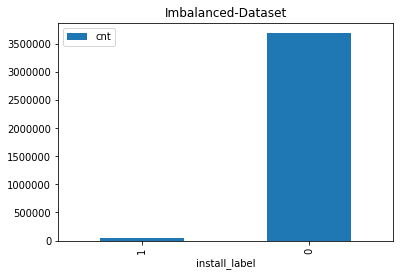

In [17]:
stats.toPandas().plot(kind='bar', title='Imbalanced-Dataset',x='install_label',y='cnt');

In [18]:
sqlContext.sql('''
    select advertisement_id, install_label, count(1) as cnt 
    from df_train_table 
    where 1=1
    group by 1,2 
    order by 3 desc
''').show(10, False)

+------------------------+-------------+-----+
|advertisement_id        |install_label|cnt  |
+------------------------+-------------+-----+
|5c3bfb0b36c2c6cc18710e7b|0            |41482|
|5c385d02ee4549000d8b9ddd|0            |36345|
|5c0f2ff2f4ee9d00225714c2|0            |32688|
|5afbea849f23a400284f2619|0            |30184|
|5c26db700f371292325680ec|0            |28402|
|5bd2b810eb4bb3b817722baa|0            |26347|
|5af41f3346d16a019f9d327d|0            |24042|
|5c333b4d1d94abf8a325e55a|0            |23469|
|5ba35fbb478f4102c28b1811|0            |22620|
|5bd2ccefc9c2110ad461c1b3|0            |22267|
+------------------------+-------------+-----+
only showing top 10 rows



In [19]:
sqlContext.sql('''
    select count( distinct location)
    from df_train_table 
   ''').show(100, False)

+------------------------+
|count(DISTINCT location)|
+------------------------+
|221                     |
+------------------------+



In [20]:
sqlContext.sql('''
    select location, install_label, count(1) as cnt 
    from df_train_table 
    where 1=1
    group by 1,2 
    order by 3 desc
''').show(10, False)

+--------+-------------+------+
|location|install_label|cnt   |
+--------+-------------+------+
|US      |0            |571342|
|RU      |0            |284031|
|IN      |0            |263013|
|BR      |0            |197981|
|DE      |0            |146836|
|GB      |0            |125766|
|FR      |0            |123234|
|TR      |0            |121841|
|CN      |0            |116602|
|ID      |0            |114815|
+--------+-------------+------+
only showing top 10 rows



In [21]:
sqlContext.sql('''
    select device_os, install_label, count(1) as cnt 
    from df_train_table 
    where device_os is not null
    group by 1,2 
    order by 3 desc
''').show(100, False)

+---------+-------------+-------+
|device_os|install_label|cnt    |
+---------+-------------+-------+
|android  |0            |2696965|
|ios      |0            |997228 |
|android  |1            |32079  |
|ios      |1            |12665  |
+---------+-------------+-------+



In [22]:
columns_to_be_dropped=['dummy1','dummy2','dummy3','dummy4']
df_train_spark2=df_train_spark2.drop(*columns_to_be_dropped)


In [23]:
df_train_spark2.printSchema()

root
 |-- unique_id: string (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- advertisement_id: string (nullable = true)
 |-- device_os: string (nullable = true)
 |-- software_ver: string (nullable = true)
 |-- Game_Id: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- ad_start_Count: integer (nullable = true)
 |-- ad_view_Count: integer (nullable = true)
 |-- ad_click_Count: integer (nullable = true)
 |-- ad_install_Count: integer (nullable = true)
 |-- device: string (nullable = true)
 |-- install_label: integer (nullable = true)



In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import OneHotEncoderEstimator

In [25]:
#There are better way to perform oversampling (e.g. SMOTE Synthetic Minority Over-sampling ). 
#However, I am using under-sampling to keep the solution simple

df_binary_zero = df_train_spark2[df_train_spark2['install_label'] == 0]
df_binary_one = df_train_spark2[df_train_spark2['install_label'] == 1]

df_binary_zero_under = df_binary_zero.rdd.takeSample(withReplacement=False,
                                                     num=df_binary_one.count()
                                                     )

df_binary_zero_under1 = my_spark.createDataFrame(df_binary_zero_under)

spark_df = df_binary_one.union(df_binary_zero_under1)

In [26]:
spark_df.groupBy('install_label').count().show()

+-------------+-----+
|install_label|count|
+-------------+-----+
|            0|44744|
|            1|44744|
+-------------+-----+



In [27]:
spark_df.printSchema()

root
 |-- unique_id: string (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- advertisement_id: string (nullable = true)
 |-- device_os: string (nullable = true)
 |-- software_ver: string (nullable = true)
 |-- Game_Id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- ad_start_Count: long (nullable = true)
 |-- ad_view_Count: long (nullable = true)
 |-- ad_click_Count: long (nullable = true)
 |-- ad_install_Count: long (nullable = true)
 |-- device: string (nullable = true)
 |-- install_label: long (nullable = true)



In [28]:
spark_df.dtypes

[('unique_id', 'string'),
 ('timestamp', 'date'),
 ('advertisement_id', 'string'),
 ('device_os', 'string'),
 ('software_ver', 'string'),
 ('Game_Id', 'bigint'),
 ('location', 'string'),
 ('ad_start_Count', 'bigint'),
 ('ad_view_Count', 'bigint'),
 ('ad_click_Count', 'bigint'),
 ('ad_install_Count', 'bigint'),
 ('device', 'string'),
 ('install_label', 'bigint')]

<font size="3"><b>Verify Categorical and Numeric Features before Feature Engineering

In [29]:
cat_cols = [i[0] for i in spark_df.dtypes if i[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

num_cols = [i[0] for i in spark_df.dtypes if i[1].startswith('int') | i[1].startswith('bigint')][1:]
print(str(len(num_cols)) + '  numerical features')

time_cols = [i[0] for i in spark_df.dtypes if i[1].startswith('date')]
print(str(len(time_cols)) + '  date features')

6  categorical features
5  numerical features
1  date features


In [30]:
spark_df.createOrReplaceTempView("spark_df_table")

In [31]:
spark_df= sqlContext.sql('''
select tbl.*, 
CAST (tbl.timestamp as String) timestamp_s
from spark_df_table tbl
''')

In [34]:
spark_df.printSchema()

root
 |-- unique_id: string (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- advertisement_id: string (nullable = true)
 |-- device_os: string (nullable = true)
 |-- software_ver: string (nullable = true)
 |-- Game_Id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- ad_start_Count: long (nullable = true)
 |-- ad_view_Count: long (nullable = true)
 |-- ad_click_Count: long (nullable = true)
 |-- ad_install_Count: long (nullable = true)
 |-- device: string (nullable = true)
 |-- install_label: long (nullable = true)
 |-- timestamp_s: string (nullable = true)



<font size="5"><b>Feature Engineering


<font size="5"><b> SPARK PIPELINE</font>

<font size="3">
<p><b><u>StringIndexer</u></b> - It encodes a string column of labels to a column of label indices<p>
<p><b><u>OneHotEncoder</u></b> - It maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. <p>
<p><b><u>VectorAssembler</u></b> - It is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees
<p><b><u>StandardScaler</u></b>- It transforms a dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean. It takes parameters:
    

In [40]:
stringIndexer1 = StringIndexer(handleInvalid='keep', inputCol='advertisement_id', outputCol="advertisement_id_i") 
stringIndexer2 = StringIndexer(handleInvalid='keep', inputCol='device_os',   outputCol="device_os_i") 
stringIndexer3 = StringIndexer(handleInvalid='keep', inputCol='software_ver', outputCol="software_ver_i") 
stringIndexer4 = StringIndexer(handleInvalid='keep', inputCol='location', outputCol="location_i") 
stringIndexer5 = StringIndexer(handleInvalid='keep', inputCol='device', outputCol="device_i") 
stringIndexer6 = StringIndexer(handleInvalid='keep', inputCol='timestamp_s', outputCol="timestamp_i") 

oneHotEncoder = OneHotEncoderEstimator(inputCols=
                                            ["advertisement_id_i",
                                            "device_os_i",
                                            "software_ver_i",
                                            "location_i",
                                            "device_i",
                                            "timestamp_i",
                                            ],
                                        outputCols=["advertisement_id_o",
                                            "device_os_o",
                                            "software_ver_o",
                                            "location_o",
                                            "device_o",
                                            "timestamp_o",
                                            ]
                                 )

unscaled_features =["advertisement_id_o","device_os_o","software_ver_o","location_o","device_o","timestamp_o"
                   ,"Game_Id","ad_start_Count","ad_view_Count","ad_click_Count","install_label"]


vectorAssembler = VectorAssembler(inputCols=unscaled_features, outputCol="vector_features")


standardScaler = StandardScaler(inputCol="vector_features", outputCol="scaled_features",withStd=True, withMean=False)
#standardScaler = MinMaxScaler(inputCol="unscaled_features", outputCol="scaled_features")




stages = [stringIndexer1,
         stringIndexer2, 
         stringIndexer3, 
         stringIndexer4, 
         stringIndexer5, 
         stringIndexer6, 
         oneHotEncoder,
         vectorAssembler,
         standardScaler
         ]

pipeline = Pipeline(stages=stages)
model = pipeline.fit(spark_df)
pipeline_df = model.transform(spark_df)



In [41]:
pipeline_df = pipeline_df.withColumnRenamed("install_label", "label")

In [42]:
pipeline_df.dtypes

[('unique_id', 'string'),
 ('timestamp', 'date'),
 ('advertisement_id', 'string'),
 ('device_os', 'string'),
 ('software_ver', 'string'),
 ('Game_Id', 'bigint'),
 ('location', 'string'),
 ('ad_start_Count', 'bigint'),
 ('ad_view_Count', 'bigint'),
 ('ad_click_Count', 'bigint'),
 ('ad_install_Count', 'bigint'),
 ('device', 'string'),
 ('label', 'bigint'),
 ('timestamp_s', 'string'),
 ('advertisement_id_i', 'double'),
 ('device_os_i', 'double'),
 ('software_ver_i', 'double'),
 ('location_i', 'double'),
 ('device_i', 'double'),
 ('timestamp_i', 'double'),
 ('timestamp_o', 'vector'),
 ('software_ver_o', 'vector'),
 ('advertisement_id_o', 'vector'),
 ('device_os_o', 'vector'),
 ('location_o', 'vector'),
 ('device_o', 'vector'),
 ('vector_features', 'vector'),
 ('scaled_features', 'vector')]

<font size="3"><b> Train Test Split

In [43]:
(trainingData, testData) = pipeline_df.randomSplit([0.7, 0.3])

In [44]:
trainingData.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|31294|
|    1|31347|
+-----+-----+



In [45]:
testData.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|13450|
|    1|13397|
+-----+-----+



<font size="4"><b> Train a Spark ML RandomForest model</font>

In [46]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")

<font size="4"><b> Hyper-Parameter Tuning &  Cross Validation


In [47]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Hyper-Parameter Tuning
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [40, 60, 80, 100]) \
    .build()

# Cross Validation
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3) 


<font size="4"><b>Fit model to data train

In [48]:
model=crossval_rf.fit(trainingData)

<font size="4"><b>Make predictions.

In [51]:
predictions = model.transform(testData)

In [52]:
predictions.summary

<bound method DataFrame.summary of DataFrame[unique_id: string, timestamp: date, advertisement_id: string, device_os: string, software_ver: string, Game_Id: bigint, location: string, ad_start_Count: bigint, ad_view_Count: bigint, ad_click_Count: bigint, ad_install_Count: bigint, device: string, label: bigint, timestamp_s: string, advertisement_id_i: double, device_os_i: double, software_ver_i: double, location_i: double, device_i: double, timestamp_i: double, timestamp_o: vector, software_ver_o: vector, advertisement_id_o: vector, device_os_o: vector, location_o: vector, device_o: vector, vector_features: vector, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]>

In [54]:
# Select example rows to display.
predictions.select("unique_id","probability","prediction","label").show(20, False)

+------------------------+----------------------------------------+----------+-----+
|unique_id               |probability                             |prediction|label|
+------------------------+----------------------------------------+----------+-----+
|5c33eba781a8c737c2ec42de|[0.49086168693113674,0.5091383130688633]|1.0       |1    |
|5c33ebf3c4e4943aa8d34284|[0.49091789641817646,0.5090821035818236]|1.0       |1    |
|5c33edf170df593bb1449cdc|[0.47250782851328116,0.5274921714867189]|1.0       |1    |
|5c33efc439eec03b7c79a024|[0.48925811886795517,0.5107418811320449]|1.0       |1    |
|5c33f14221dfc23be5d89ddb|[0.46993750326561995,0.5300624967343801]|1.0       |1    |
|5c33f16784ee253d24c108a6|[0.5034721368858157,0.49652786311418423]|0.0       |1    |
|5c33f2c87cd9e33d59178db2|[0.4864659990220912,0.5135340009779088] |1.0       |1    |
|5c33f985ab1b4d3f367114d7|[0.48925811886795517,0.5107418811320449]|1.0       |1    |
|5c33fbf3001c943fd5fa87da|[0.49227419772595127,0.5077258022740487

<font size="3"><b> Model Performance Measures</b>

<p>Accuracy - Model performance</p>


<u>Confusion Matrix</u>:: a table showing correct predictions and types of incorrect predictions.

<u>Precision</u>:: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

<u>Recall</u>:: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

<u>F1</u>:: Score: the weighted average of precision and recall.

In [55]:
#Evaluate model by calculating accuracy and area under curve (AUC)
rf_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
rf_hyper_AUC  = rf_hyper_eval.evaluate(predictions)
#rf_hyper_ACC  = rf_hyper_eval.evaluate(predictions, {rf_hyper_eval.metricName:"accuracy"})

print("Performance Measure")
#print("Accuracy = %0.2f" % rf_hyper_ACC)
print("AUC = %.2f" % rf_hyper_AUC)

Performance Measure
AUC = 0.92


In [56]:
cm_rf_result_hyper = predictions.crosstab("prediction", "label")
cm_rf_result_hyper = cm_rf_result_hyper.toPandas()
cm_rf_result_hyper


,prediction_label,0,1
0,1.0,1551,11452
1,0.0,11899,1945


In [57]:
predictions.select('prediction','label').distinct().show()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|    1|
|       0.0|    1|
|       1.0|    0|
|       0.0|    0|
+----------+-----+



In [58]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_rf_result_hyper["1"][0]
FP = cm_rf_result_hyper["0"][0]
TN = cm_rf_result_hyper["0"][1]
FN = cm_rf_result_hyper["1"][1]


Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity/Recall = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.87
Sensitivity/Recall = 0.85
Specificity = 0.88
Precision = 0.88


In [59]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.360859


In [60]:
sqlContext.clearCache()

<b><font size="5"><p>THANK YOU </p></b>